# Initial Setup

In [103]:
# For better sorting of column names in some exercises.
!pip install natsort


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [104]:
# Initial imports.
from typing import Tuple, List

import numpy as np
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from natsort import natsorted
from functools import partial
from ISLP import load_data
from l0bnb import fit_path

from matplotlib.pyplot import subplots
from matplotlib import pyplot as plt
from statsmodels.api import OLS

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

from ISLP.models import ModelSpec as MS
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)

## Laboratory: Linear Models and Regularization Methods

### Subset Selection Methods

#### Forward Selection

In [105]:
Hitters = load_data("Hitters")

np.isnan(Hitters["Salary"]).sum()

59

In [106]:
Hitters: pd.DataFrame = Hitters.dropna()

# Show it.
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [107]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp statistic.
    """
    
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [108]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)

Y: np.array = np.array(Hitters["Salary"])
X: pd.DataFrame = design.transform(Hitters)

sigma2: float = OLS(Y,X).fit().scale

sigma2

99591.3561796822

In [109]:
neg_Cp = partial(nCp, sigma2)
neg_Cp?

Signature:      neg_Cp(estimator, X, Y)
Call signature: neg_Cp(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function nCp at 0x7fe0aad4b400>, 99591.3561796822)
File:           /usr/lib/python3.10/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [110]:
strategy = Stepwise.first_peak(
    model_spec=design,
    direction="forward",
    max_terms=len(design.terms)
)

In [111]:
%%time

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

CPU times: user 1.83 s, sys: 84 µs, total: 1.83 s
Wall time: 1.83 s


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [112]:
%%time

hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

CPU times: user 1.08 s, sys: 9.27 ms, total: 1.09 s
Wall time: 1.09 s


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [113]:
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7fe0aafc7280>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7fe0cff012d0>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7fe0cff013f0>, 19)))

In [114]:
%%time

full_path.fit(Hitters, Y)
Yhat_in: np.ndarray = full_path.predict(Hitters)
Yhat_in.shape

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.04 s


(263, 20)

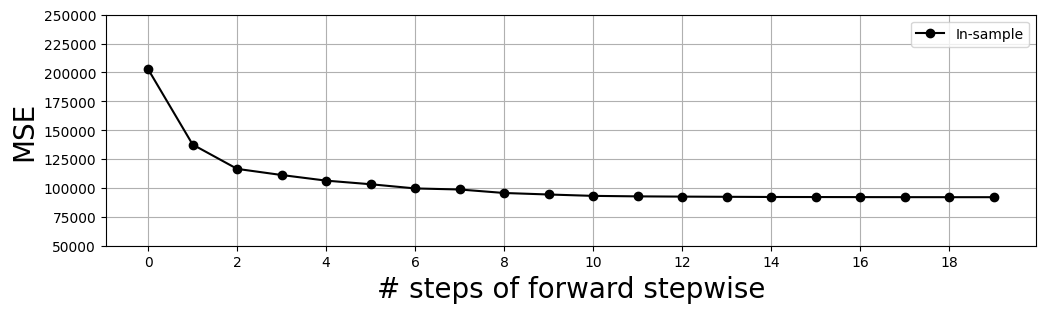

In [115]:
mse_fig, ax = subplots(figsize=(12, 3))

insample_mse: np.ndarray = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps: int = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    marker="o",
    color="k",  # color black
    label="In-sample"
)
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.grid()
ax.set_ylim([50000, 250000]);

In [116]:
%%time

K: int = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv: np.ndarray = skm.cross_val_predict (full_path, Hitters, Y, cv=kfold)

Yhat_cv.shape

CPU times: user 5.09 s, sys: 9.52 ms, total: 5.1 s
Wall time: 5.1 s


(263, 20)

In [117]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    
    # Column means.
    cv_mse.append(errors.mean(0))  

cv_mse = np.array(cv_mse).T

cv_mse.shape

(20, 5)

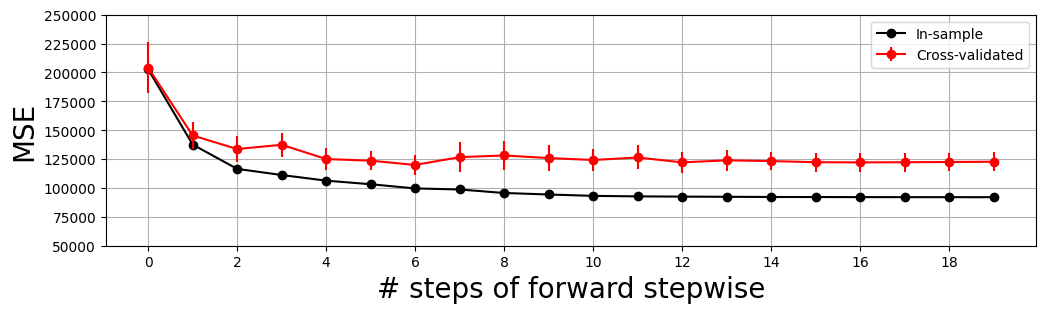

In [118]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(axis=1),
    cv_mse.std(axis=1) / np.sqrt(K),
    label="Cross-validated",
    color="red",
    marker="o"
)

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [119]:
validation = skm.ShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
)

for train_idx, test_idx in validation.split(Y):
    
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    
    validation_mse = errors.mean(0)

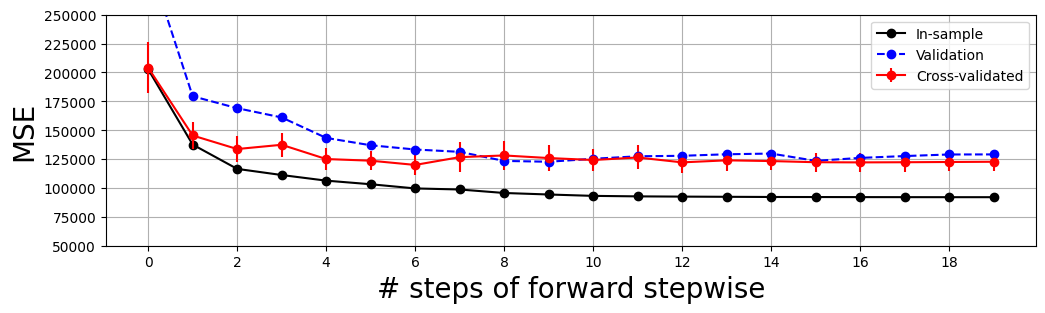

In [120]:
ax.plot(
    np.arange(n_steps), 
    validation_mse, 
    marker="o",
    color="blue",
    linestyle="--", # color blue, broken line
    label="Validation")

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [121]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

X.shape

(263, 19)

In [122]:
%%time

path = fit_path(X, Y, max_nonzeros=X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19
CPU times: user 3min 13s, sys: 0 ns, total: 3min 13s
Wall time: 4.05 s


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

#### Ridge Regression

In [123]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
Xs = X - X.mean(axis=0)[None, :]
X_scale = X.std(axis=0)
Xs = Xs / X_scale[None,:]

print(f">>> Scaled data shape: {Xs.shape}")

lambdas = 10 ** np.linspace(8, -2, 100) / Y.std() 
soln_array = skl.ElasticNet.path(X=Xs, y=Y, l1_ratio=0., alphas=lambdas)[1]

print(f">>> Number of lambdas: {lambdas.shape[0]}")
print(f">>> Solution array shape: {soln_array.shape}")

>>> Scsled data shape: (263, 19)
>>> Number of lambdas: 100
>>> Solution array shape: (19, 100)


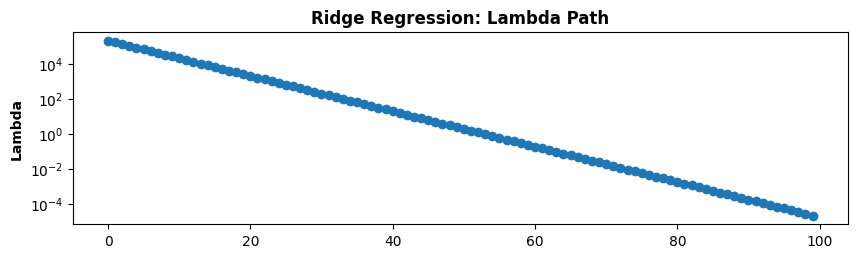

In [125]:
plt.figure(figsize=(10, 2.5))
plt.plot(lambdas, marker="o")
plt.ylabel("Lambda", weight="bold")
plt.title("Ridge Regression: Lambda Path", weight="bold")
plt.yscale("log");

In [126]:
soln_path: pd.DataFrame = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = "negative log(lambda)"

# Show the solution path.
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


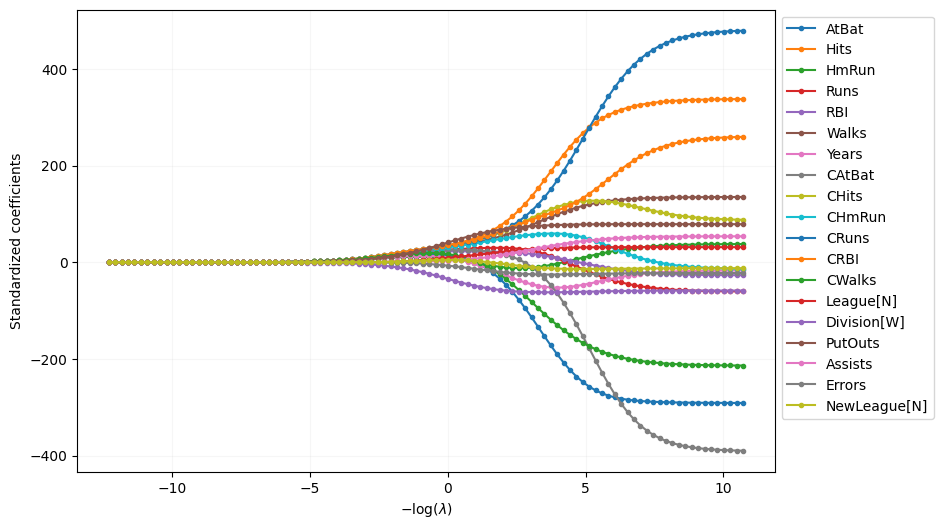

In [127]:
path_fig, ax = subplots(figsize=(9, 6)) 
soln_path.plot(ax=ax, legend=False, marker=".")
ax.set_xlabel("$-\log(\lambda)$")
ax.set_ylabel("Standardized coefficients") 

# Set legend ouside plot.
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(alpha=0.10);

In [128]:
soln_path2 = soln_path.copy()
soln_path2.index = lambdas
soln_path2.index.name = "lambda"
soln_path2

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
lambda,,,,,,,,,,,,,,,,,,,
222093.790899,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
176005.531118,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
139481.373426,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
110536.603079,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
87598.367583,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.000056,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
0.000045,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
0.000035,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


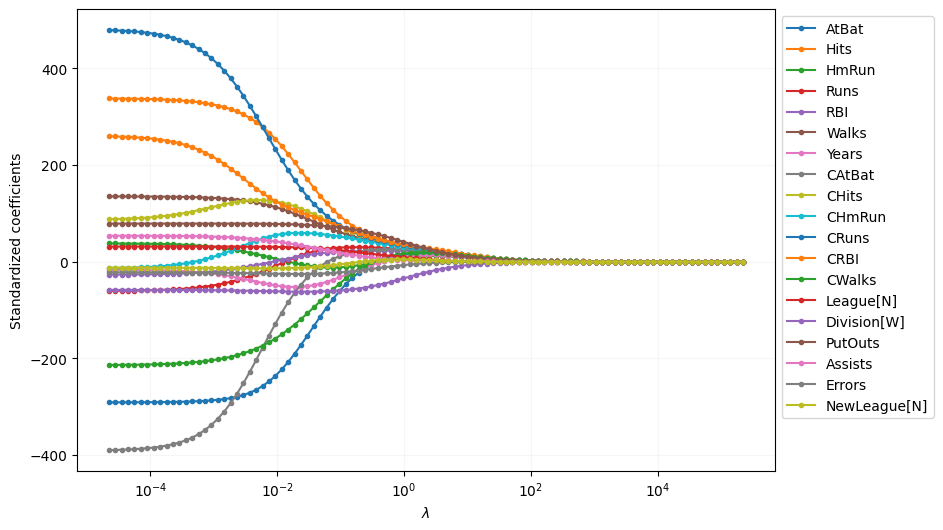

In [129]:
path_fig, ax = subplots(figsize=(9, 6)) 
soln_path2.plot(ax=ax, legend=False, marker=".")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Standardized coefficients") 

# Set legend ouside plot.
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(alpha=0.10);
ax.set_xscale("log")

In [130]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)

pipe = Pipeline(
    steps=[
        ("scaler", scaler), 
        ("ridge", ridge)
    ]
) 

pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.2437476613348855, l1_ratio=0))])

#### Estimating Test Error of Ridge Regression

In [131]:
validation = skm.ShuffleSplit(
    n_splits=1, 
    test_size=0.5,
    random_state=0
)

ridge.alpha = 0.01

results = skm.cross_validate(
    estimator=ridge,
    X=X,
    y=Y,
    scoring="neg_mean_squared_error",
    cv=validation,
)

# Show it.
results

{'fit_time': array([0.00380349]),
 'score_time': array([0.00058818]),
 'test_score': array([-134214.00419204])}

In [132]:
ridge.alpha = 1e10

results = skm.cross_validate(
    estimator=ridge,
    X=X,
    y=Y,
    scoring="neg_mean_squared_error",
    cv=validation,
)

# Show it.
results

{'fit_time': array([0.00366592]),
 'score_time': array([0.00069332]),
 'test_score': array([-231788.32155285])}

In [133]:
for train_idx, test_idx in validation.split(X, Y):
    prediction = Y[train_idx].mean()
    print(">>> Mean of Y in training set: {prediction}", )

# Calculate the MSE of this prediction in test split.
mse = ((prediction - Y[test_idx])**2).mean()
print(f">>> MSE of this prediction: {mse}")

>>> Mean of Y in training set: {prediction}
>>> MSE of this prediction: 231853.4150633351


In [134]:
# Percentual error.
np.abs((- results["test_score"] - mse) / (- results["test_score"]) * 100)[0]

0.02808317090923323

In [135]:
param_grid = {
    "ridge__alpha": lambdas
}

grid = skm.GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=validation,
)

grid.fit(X, Y)

# Show best parameters.
grid.best_params_

{'ridge__alpha': 0.005899006046740854}

In [136]:
# Show best estimator.
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740854, l1_ratio=0))])

In [137]:
%%time

grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')

grid.fit(X, Y) 

CPU times: user 2.88 s, sys: 0 ns, total: 2.88 s
Wall time: 2.88 s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])},
             scoring='neg_mean_squared_error')

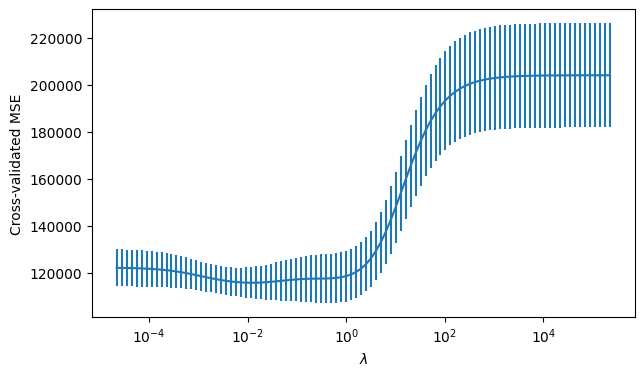

In [138]:
ridge_fig, ax = subplots(figsize=(7, 4)) 

ax.errorbar(
    lambdas,
    -grid.cv_results_["mean_test_score"],
    yerr=grid.cv_results_["std_test_score"] / np.sqrt(K)
)

ax.set_xscale("log")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("Cross-validated MSE", fontsize=10);

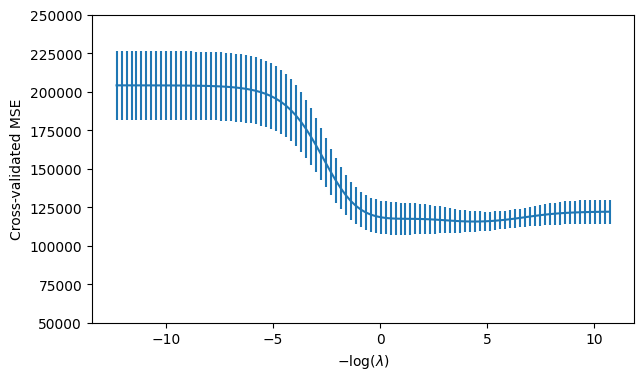

In [139]:
ridge_fig, ax = subplots(figsize=(7, 4)) 

ax.errorbar(
    -np.log(lambdas),
    -grid.cv_results_["mean_test_score"],
    yerr=grid.cv_results_["std_test_score"] / np.sqrt(K)
)

ax.set_ylim([50000,250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=10)
ax.set_ylabel("Cross-validated MSE", fontsize=10);

In [140]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring="r2")

grid_r2.fit(X, Y);

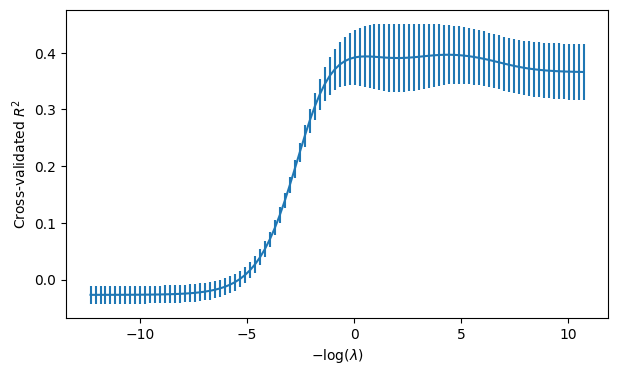

In [141]:
ridge_fig, ax = subplots(figsize=(7, 4)) 

ax.errorbar(
    -np.log(lambdas),
    grid_r2.cv_results_["mean_test_score"], 
    yerr=grid_r2.cv_results_["std_test_score"] / np.sqrt(K)
)

ax.set_xlabel("$-\log(\lambda)$", fontsize=10)
ax.set_ylabel("Cross-validated $R^2$", fontsize=10);

#### Fast Cross-Validation for Solution Paths

## Exercises

### Ancillar Functions

In [142]:
def adjust_linear_model(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[OLS, float, float, float, float]:
    """
    Adjust a linear model with all predictors.
    """
    
    linear_model = OLS(endog=dfY, exog=dfX).fit()

    return linear_model, linear_model.ssr, linear_model.rsquared, linear_model.bic, linear_model.aic


def forward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame,
        verbose: bool = False
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Forward stepwise selection.
    """
    
    if verbose:
        print(">>> Starting forward stepwise selection...")

    # Initially all predictor are available.
    all_features: List[str] = dfX.columns.to_list()
    available_features: List[str] = dfX.columns.to_list()
    used_features: List[str] = []

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(used_features) < len(all_features):

        # Loop over all predictors.
        for feature in available_features:
            
            # If feature not already used.
            if feature not in used_features:

                # Candidates to test.
                tested_features: List[str] = used_features + [feature]

                if verbose:
                    print(f">>> Testing features: {tested_features}")

                # Fit model with current feature.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                if verbose:
                    print(f"\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    best_feature: str = feature

                    # Best model.
                    best_model: OLS = model

        # Update lists.
        used_features.append(best_feature)
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        available_features.remove(best_feature)
        best_models.append(best_model)

        if verbose:
            print(f"\t* Diagnostic: used features: {used_features}, Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf

    if verbose:
        print("\n>>> Done!")    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models


def backward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame,
        verbose: bool = False
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Backward stepwise selection.
    """
    
    # Skeleton for backward stepwise selection.
    all_features: List[str] = dfX.columns.to_list()
    tested_features: List[str] = all_features.copy()
    candidates: List[str] = all_features.copy()

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Adjust linear model with all predictors.
    model, rss, r2, bic, aic = adjust_linear_model(dfX, dfY)

    # Calculate cp.
    cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])    

    n_features.append(len(all_features))
    rss_list.append(rss)
    r2_list.append(r2)
    bic_list.append(bic)
    aic_list.append(aic)
    cp_list.append(cp)
    best_models.append(model)

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(candidates) > 1:

        if verbose:
            print(f">>> Candidates to remove: {candidates}")

        # Loop over candidates to be removed.
        for candidate in all_features:

            # Is this a valid candidate?
            if candidate in candidates:

                # Features to be tested.
                tested_features = natsorted(list(set(candidates) - set([candidate])))

                if verbose:
                    print(f"\t* Exclude {candidate}:")

                # Adjust model and calculate metrics.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                if verbose:
                    print(f"\t\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    removed_feature: str = candidate
                    used_features: List[str] = tested_features

                    # Best model.
                    best_model: OLS = model
                
        # Select feature to be removed.
        if verbose:
            print(f"\t* Removed feature: {removed_feature}")
        candidates.remove(removed_feature)    

        # Update lists.
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        best_models.append(best_model)

        if verbose:
            print(f"\t* Diagnostic:")
            print(f"\t\t* used features: {used_features}")
            print(f"\t\t* Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models

### Conceptual

#### 1

(a) Best subset selection has the smallest training RSS bacause it searchs for all possible combinations that has exactly $k$ predictors, while forward and backward stepwise selection don't. 

(b) We cannot state for sure which of thre three models with $k$ predictors will have the smallest test RSS;

(c) 
- i. True;
- ii. True;
- iii. False;
- iv. False;
- v. False; 

#### 2

(a)False; False; True; False;

(b)False; False; True; False;

(c) False; True; False; False;

### Applied

#### 8

In [143]:
# a)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))

In [144]:
# b)

# Real parameters that generate data.
B0: float = 3
B1: float = 4
B2: float = 2
B3: float = 1

# Response.
Y: np.ndarray = B0 + B1 * X + B2 * (X ** 2) + B3 * (X ** 3) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])
dfY

,Y
0,2.984842
1,2.114810
2,-6.371912
3,-0.711277
4,0.069361
...,...
95,18.954107
96,-0.240528
97,18.430823
98,0.941642


In [145]:
# c)

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X ** i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.0,-0.165868,0.027512,-0.004563,0.000757,-0.000126,0.000021,-0.000003,5.729265e-07,-9.503012e-08,1.576245e-08
1,1.0,-0.475971,0.226548,-0.107830,0.051324,-0.024429,0.011627,-0.005534,2.634168e-03,-1.253787e-03,5.967662e-04
2,1.0,-2.228720,4.967193,-11.070481,24.673002,-54.989211,122.555550,-273.141996,6.087570e+02,-1.356749e+03,3.023813e+03
3,1.0,-1.185132,1.404538,-1.664563,1.972727,-2.337942,2.770770,-3.283729,3.891652e+00,-4.612122e+00,5.465974e+00
4,1.0,-1.014701,1.029618,-1.044754,1.060113,-1.075697,1.091511,-1.107557,1.123839e+00,-1.140360e+00,1.157124e+00
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.529677,2.339911,3.579308,5.475185,8.375263,12.811446,19.597373,2.997765e+01,4.585611e+01,7.014504e+01
96,1.0,-0.263002,0.069170,-0.018192,0.004784,-0.001258,0.000331,-0.000087,2.289110e-05,-6.020396e-06,1.583374e-06
97,1.0,1.603907,2.572518,4.126080,6.617848,10.614414,17.024534,27.305770,4.379592e+01,7.024458e+01,1.126658e+02
98,1.0,-0.874035,0.763937,-0.667708,0.583600,-0.510087,0.445834,-0.389675,3.405894e-01,-2.976871e-01,2.601890e-01


In [146]:
# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1516.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           7.85e-95
Time:                        14:47:37   Log-Likelihood:                -128.88
No. Observations:                 100   AIC:                             279.8
Df Residuals:                      89   BIC:                             308.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             2.8282      0.201     14.090      0.000       2.429       3.227
X1             4.0141      0.441      9.097      0.000       3.137       4.891
X2             2.2715      0.742      3.060      0.003       0.797       3.746
X3             1.5555      0.599      2.598      0.011       0.366       2.745
X4            -0.0252      0.690     -0.036      0.971      -1.396       1.345
X5            -0.2721      0.248     -1.097      0.276      -0.765       0.221
X6            -0.0098      0.227     -0.043      0.966      -0.461       0.441
X7             0.0375      0.039      0.958      0.341      -0.040       0.115
X8          1.343e-05      0.030      0.000      1.000      -0.059       0.059
X9            -0.0015      0.002     -0.720      0.473      -0.006       0.003
X10            0.0001      0.001      0.075      0.940      -0.003       0.003
==============================================================================
Omnibus:                        0.760   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.884
Skew:                          -0.175   Prob(JB):                        0.643
Kurtosis:                       2.700   Cond. No.                     2.18e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [147]:
# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

In [148]:
# Run forward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = forward_stepwise_selection(dfX, dfY)

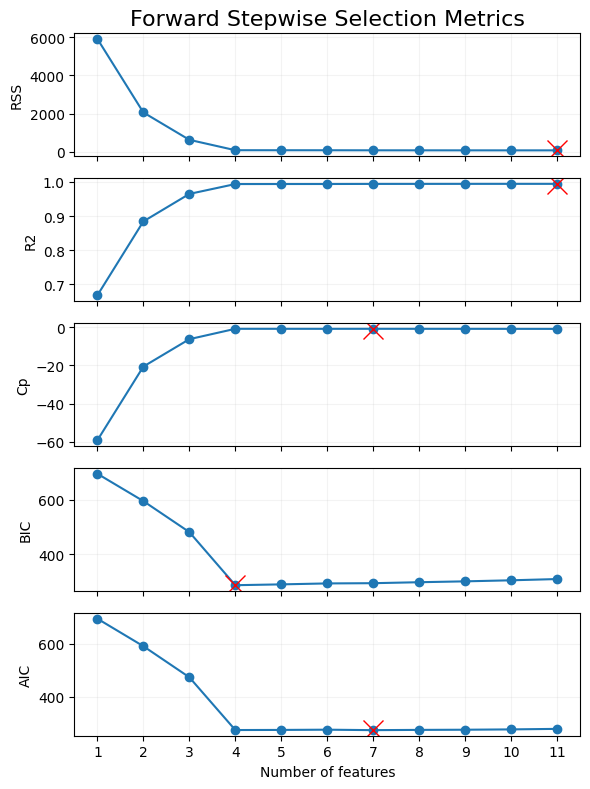

In [149]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Forward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [150]:
# Expected coefficients.
df_compare_forward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="forward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="forward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="forward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="forward_r2")

# Join all dataframes.
df_compare_forward = df_compare_forward.join(df_cp, how="outer")
df_compare_forward = df_compare_forward.join(df_bic, how="outer")
df_compare_forward = df_compare_forward.join(df_aic, how="outer")  
df_compare_forward = df_compare_forward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_forward = df_compare_forward.round(3)

# Better sorting of the index.
df_compare_forward = df_compare_forward.reindex(natsorted(df_compare_forward.index))

df_compare_forward

,true,forward_cp,forward_bic,forward_aic,forward_r2
X0,3.0,2.752,3.005,2.752,2.828
X1,4.0,4.506,4.280,4.506,4.014
X2,2.0,2.548,1.977,2.548,2.271
X3,1.0,0.845,0.962,0.845,1.556
X4,0.0,-0.182,NaN,-0.182,-0.025
X5,0.0,NaN,NaN,NaN,-0.272
X6,0.0,0.014,NaN,0.014,-0.010
X7,0.0,0.001,NaN,0.001,0.038
X8,0.0,NaN,NaN,NaN,0.000
X9,0.0,NaN,NaN,NaN,-0.001


In [151]:
# c)

# Run backward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = backward_stepwise_selection(dfX, dfY)

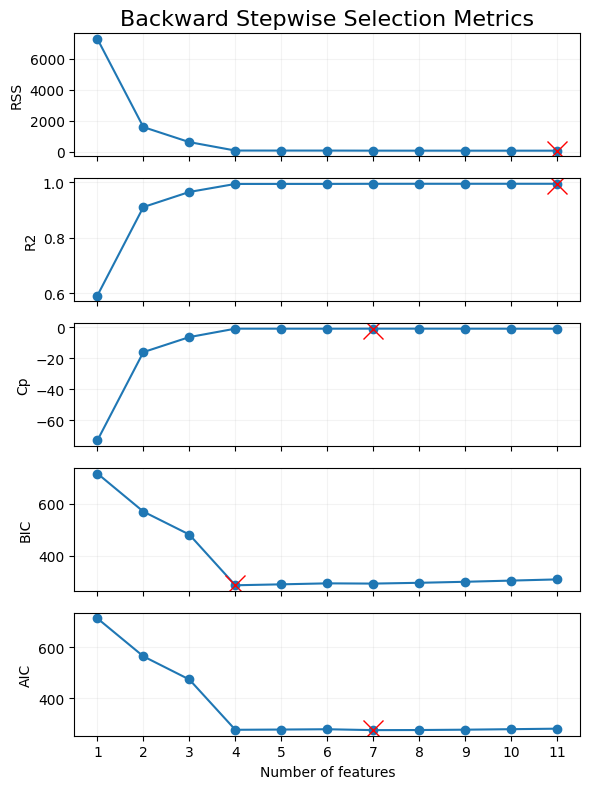

In [152]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Backward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [153]:
# Initialize.
df_compare_backward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="backward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="backward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="backward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="backward_r2")

# Join all dataframes.
df_compare_backward = df_compare_backward.join(df_cp, how="outer")
df_compare_backward = df_compare_backward.join(df_bic, how="outer")
df_compare_backward = df_compare_backward.join(df_aic, how="outer")  
df_compare_backward = df_compare_backward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_backward = df_compare_backward.round(3)

# Better sorting of the index.
df_compare_backward = df_compare_backward.reindex(natsorted(df_compare_backward.index))

# Show it.
df_compare_backward

,true,backward_cp,backward_bic,backward_aic,backward_r2
X0,3.0,2.825,3.005,2.825,2.828
X1,4.0,4.557,4.280,4.557,4.014
X2,2.0,2.242,1.977,2.242,2.271
X3,1.0,0.807,0.962,0.807,1.556
X4,0.0,NaN,NaN,NaN,-0.025
X5,0.0,NaN,NaN,NaN,-0.272
X6,0.0,-0.013,NaN,-0.013,-0.010
X7,0.0,0.002,NaN,0.002,0.038
X8,0.0,NaN,NaN,NaN,0.000
X9,0.0,NaN,NaN,NaN,-0.001


In [154]:
# Join results dataframes.
df_results: pd.DataFrame = pd.concat([
        df_compare_forward, 
        df_compare_backward.drop(columns=["true"])
    ], 
    axis=1
).T

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,3.000,4.000,2.000,1.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0
forward_cp,2.752,4.506,2.548,0.845,-0.182,NaN,0.014,0.001,NaN,NaN,NaN
forward_bic,3.005,4.280,1.977,0.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forward_aic,2.752,4.506,2.548,0.845,-0.182,NaN,0.014,0.001,NaN,NaN,NaN
forward_r2,2.828,4.014,2.271,1.556,-0.025,-0.272,-0.010,0.038,0.0,-0.001,0.0
backward_cp,2.825,4.557,2.242,0.807,NaN,NaN,-0.013,0.002,NaN,NaN,0.0
backward_bic,3.005,4.280,1.977,0.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backward_aic,2.825,4.557,2.242,0.807,NaN,NaN,-0.013,0.002,NaN,NaN,0.0
backward_r2,2.828,4.014,2.271,1.556,-0.025,-0.272,-0.010,0.038,0.0,-0.001,0.0


In [155]:
%%time

# e)

# Exclude constant term.
X: np.array = np.asarray(dfX.drop(columns=["X0"]))
y: np.array = dfY["Y"].values

# Hyperparameters.
lambdas: np.array = 10 ** np.linspace(6, -5, 100) / y.std() 
K: int = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

# Lasso with cross-validation.
lassocv = skl.ElasticNetCV(l1_ratio=1.0, alphas=lambdas, cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipelinecv = Pipeline(steps=[("scaler", scaler), ("lassocv", lassocv)])

# Fit the models.
pipelinecv.fit(X, y)

# Show results.
tunned_lasso = pipelinecv.named_steps["lassocv"]
tunned_lasso

CPU times: user 259 ms, sys: 0 ns, total: 259 ms
Wall time: 258 ms


ElasticNetCV(alphas=array([8.70252777e+04, 6.73805120e+04, 5.21702834e+04, 4.03935557e+04,
       3.12752632e+04, 2.42153005e+04, 1.87490277e+04, 1.45166912e+04,
       1.12397468e+04, 8.70252777e+03, 6.73805120e+03, 5.21702834e+03,
       4.03935557e+03, 3.12752632e+03, 2.42153005e+03, 1.87490277e+03,
       1.45166912e+03, 1.12397468e+03, 8.70252777e+02, 6.73805120e+02,
       5.21702834e+02, 4.039355...
       1.12397468e-04, 8.70252777e-05, 6.73805120e-05, 5.21702834e-05,
       4.03935557e-05, 3.12752632e-05, 2.42153005e-05, 1.87490277e-05,
       1.45166912e-05, 1.12397468e-05, 8.70252777e-06, 6.73805120e-06,
       5.21702834e-06, 4.03935557e-06, 3.12752632e-06, 2.42153005e-06,
       1.87490277e-06, 1.45166912e-06, 1.12397468e-06, 8.70252777e-07]),
             cv=KFold(n_splits=10, random_state=0, shuffle=True), l1_ratio=1.0)

>>> Best lambda: 8.70253e-02
>>> Best CV MSE: 0.9777 +/- 0.0904


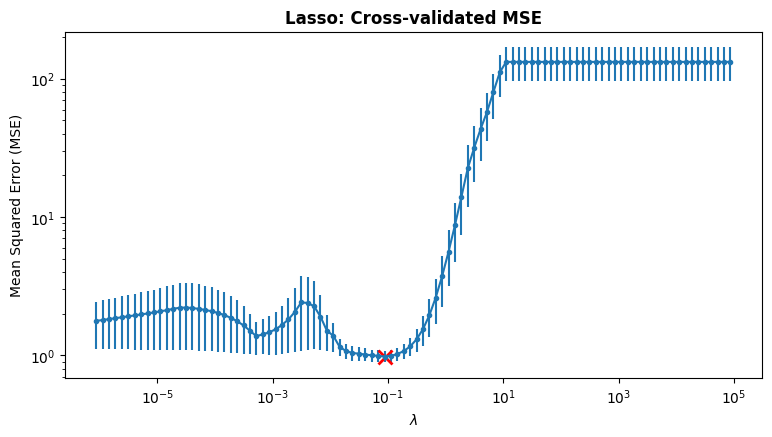

In [156]:
# Mean and error of the MSE path.
cv_mse: np.array = tunned_lasso.mse_path_.mean(axis=1)
cv_mse_err: np.array = tunned_lasso.mse_path_.std(1) / np.sqrt(K)

# Find better results.
best_idx: int = np.argmin(cv_mse)

print(f">>> Best lambda: {lambdas[best_idx]:.5e}")
print(f">>> Best CV MSE: {cv_mse[best_idx]:.4f} +/- {cv_mse_err[best_idx]:.4f}")

# Create figure.
path_fig, ax = subplots(figsize=(9, 4.5)) 

# Plot it.
ax.errorbar(
    lambdas, 
    cv_mse, 
    yerr=cv_mse_err,
    marker="."
)

# Plot better lambda as a red cross.
ax.plot(
    lambdas[best_idx],
    cv_mse[best_idx],
    marker="x",
    color="red",
    markersize=10,
    markeredgewidth=2
)

# Labels.
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Mean Squared Error (MSE)")
ax.set_title("Lasso: Cross-validated MSE", weight="bold");

In [157]:
# Lasso results.
new_row = pd.DataFrame(
    np.hstack([tunned_lasso.intercept_, tunned_lasso.coef_])[None, :], 
    columns=dfX.columns, 
    index=["lasso_cv"]
)

# Add lasso results to the results dataframe.
df_results = pd.concat([df_results, new_row], axis=0)

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,3.000000,4.000000,2.000000,1.000000,0.000,0.000000,0.000,0.000,0.0,0.000,0.0
forward_cp,2.752000,4.506000,2.548000,0.845000,-0.182,NaN,0.014,0.001,NaN,NaN,NaN
forward_bic,3.005000,4.280000,1.977000,0.962000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forward_aic,2.752000,4.506000,2.548000,0.845000,-0.182,NaN,0.014,0.001,NaN,NaN,NaN
forward_r2,2.828000,4.014000,2.271000,1.556000,-0.025,-0.272000,-0.010,0.038,0.0,-0.001,0.0
backward_cp,2.825000,4.557000,2.242000,0.807000,NaN,NaN,-0.013,0.002,NaN,NaN,0.0
backward_bic,3.005000,4.280000,1.977000,0.962000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backward_aic,2.825000,4.557000,2.242000,0.807000,NaN,NaN,-0.013,0.002,NaN,NaN,0.0
backward_r2,2.828000,4.014000,2.271000,1.556000,-0.025,-0.272000,-0.010,0.038,0.0,-0.001,0.0
lasso_cv,6.799288,5.415379,3.846733,5.963995,0.000,0.101684,0.000,0.000,-0.0,0.000,-0.0


In [158]:
# f)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))

# Real parameters that generate data.
B0: float = 10
B7: float = 2.0

# Response.
Y: np.ndarray = B0 + B7 * (X ** 7) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X ** i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()

# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

# Run forward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = forward_stepwise_selection(dfX, dfY)

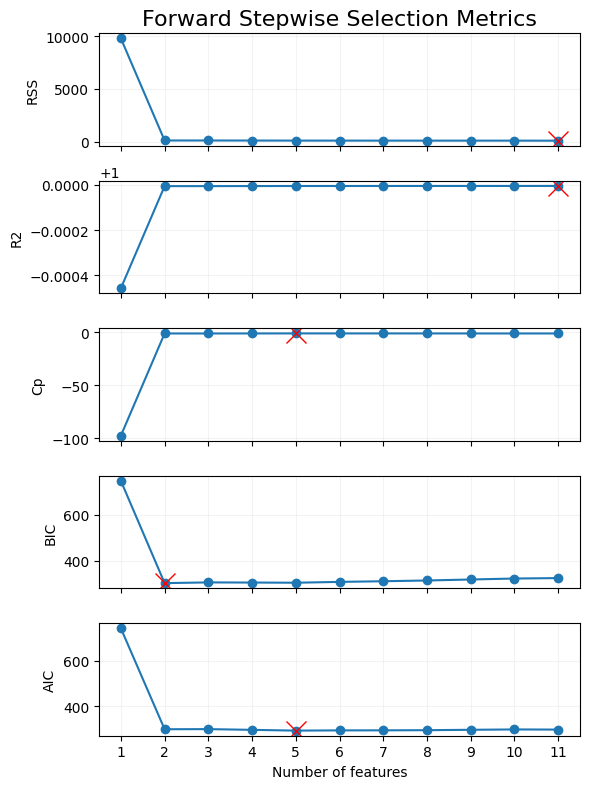

In [159]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Forward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [160]:
%%time

# Exclude constant term.
X: np.array = np.asarray(dfX.drop(columns=["X0"]))
y: np.array = dfY["Y"].values

# Hyperparameters.
lambdas: np.array = 10 ** np.linspace(10, -12, 200) / y.std() 
K: int = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

# Lasso with cross-validation.
lassocv = skl.ElasticNetCV(l1_ratio=1.0, alphas=lambdas, cv=kfold)
scaler = StandardScaler()
pipelinecv = Pipeline(steps=[("scaler", scaler), ("lassocv", lassocv)])

# Fit the models.
pipelinecv.fit(X, y)

# Show results.
tunned_lasso = pipelinecv.named_steps["lassocv"]
tunned_lasso

CPU times: user 242 ms, sys: 104 µs, total: 242 ms
Wall time: 241 ms


ElasticNetCV(alphas=array([2.17520932e+07, 1.68635223e+07, 1.30736101e+07, 1.01354437e+07,
       7.85760152e+06, 6.09168218e+06, 4.72263600e+06, 3.66126960e+06,
       2.83843495e+06, 2.20052437e+06, 1.70597797e+06, 1.32257605e+06,
       1.02533998e+06, 7.94904813e+05, 6.16257706e+05, 4.77759794e+05,
       3.70387938e+05, 2.87146860e+05, 2.22613402e+05, 1.72583210e+05,
       1.33796816e+05, 1.037272...
       2.74159670e-13, 2.12544957e-13, 1.64777550e-13, 1.27745402e-13,
       9.90358682e-14, 7.67785223e-14, 5.95232980e-14, 4.61460170e-14,
       3.57751496e-14, 2.77350335e-14, 2.15018551e-14, 1.66695228e-14,
       1.29232100e-14, 1.00188446e-14, 7.76720692e-15, 6.02160289e-15,
       4.66830634e-15, 3.61915000e-15, 2.80578132e-15, 2.17520932e-15]),
             cv=KFold(n_splits=10, random_state=0, shuffle=True), l1_ratio=1.0)

>>> Best lambda: 2.55772e-07
>>> Best CV MSE: 1.2609 +/- 0.1536


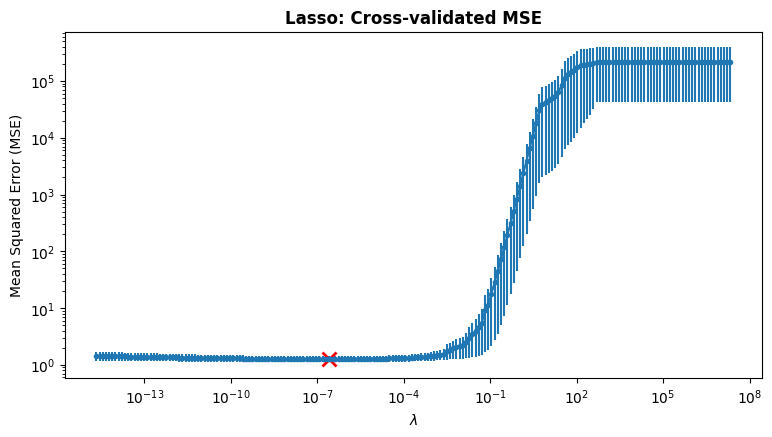

In [161]:
# Mean and error of the MSE path.
cv_mse: np.array = tunned_lasso.mse_path_.mean(axis=1)
cv_mse_err: np.array = tunned_lasso.mse_path_.std(1) / np.sqrt(K)

# Find better results.
best_idx: int = np.argmin(cv_mse)

print(f">>> Best lambda: {lambdas[best_idx]:.5e}")
print(f">>> Best CV MSE: {cv_mse[best_idx]:.4f} +/- {cv_mse_err[best_idx]:.4f}")

# Create figure.
path_fig, ax = subplots(figsize=(9, 4.5)) 

# Plot it.
ax.errorbar(
    lambdas, 
    cv_mse, 
    yerr=cv_mse_err,
    marker="."
)

# Plot better lambda as a red cross.
ax.plot(
    lambdas[best_idx],
    cv_mse[best_idx],
    marker="x",
    color="red",
    markersize=10,
    markeredgewidth=2
)

# Labels.
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Mean Squared Error (MSE)")
ax.set_title("Lasso: Cross-validated MSE", weight="bold");

In [162]:
# Expected coefficients.
df_compare_forward: pd.DataFrame = pd.DataFrame({
    "true": [B0, 0, 0, 0, 0, 0, 0, B7, 0, 0, 0]
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="forward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="forward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="forward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="forward_r2")

# Join all dataframes.
df_compare_forward = df_compare_forward.join(df_cp, how="outer")
df_compare_forward = df_compare_forward.join(df_bic, how="outer")
df_compare_forward = df_compare_forward.join(df_aic, how="outer")  
df_compare_forward = df_compare_forward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_forward = df_compare_forward.round(3)

# Better sorting of the index.
df_compare_forward = df_compare_forward.reindex(natsorted(df_compare_forward.index))

# Traspose it.
df_results = df_compare_forward.T

# Lasso results.
new_row = pd.DataFrame(
    np.hstack([tunned_lasso.intercept_, tunned_lasso.coef_])[None, :], 
    columns=dfX.columns, 
    index=["lasso_cv"]
)

# Add lasso results to the results dataframe.
df_results = pd.concat([df_results, new_row], axis=0)

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,10.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000
forward_cp,9.7470,NaN,0.261000,NaN,NaN,NaN,NaN,2.021000,NaN,-0.005000,-0.00100
forward_bic,9.9210,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
forward_aic,9.7470,NaN,0.261000,NaN,NaN,NaN,NaN,2.021000,NaN,-0.005000,-0.00100
forward_r2,9.9190,0.256000,-1.105000,0.642000,1.751000,-0.908000,-0.837000,2.319000,0.173000,-0.033000,-0.01400
lasso_cv,-52.5099,9.269381,-2.227624,-63.795009,12.073793,203.124653,-15.147862,180.424271,-3.471445,124.204342,1.96321


#### 9

In [163]:
# Load into memory.
college_df: pd.DataFrame = pd.read_csv("/statapp/islp/data/College.csv")

# Show it.
college_df

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


>>> Mean: 3001.64
>>> Median: 1558.00
>>> Standard deviation: 3870.20


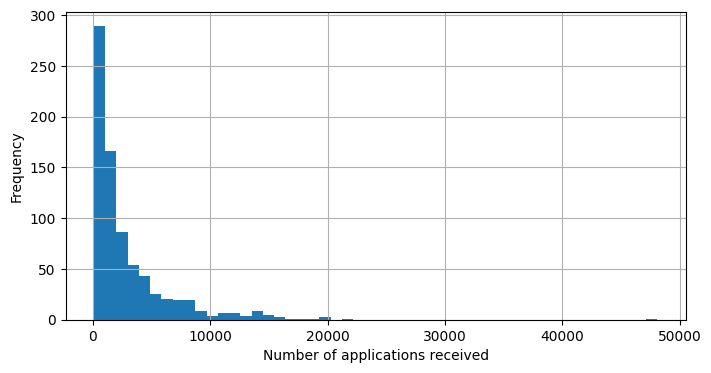

In [164]:
# Histogram target variable.
fig, ax = subplots(figsize=(8, 4))
college_df["Apps"].hist(bins=50, ax=ax)
ax.set_xlabel("Number of applications received")
ax.set_ylabel("Frequency")

# Mean and standard deviation.
print(f">>> Mean: {college_df['Apps'].mean():.2f}")
print(f">>> Median: {college_df['Apps'].median():.2f}")
print(f">>> Standard deviation: {college_df['Apps'].std():.2f}")

In [165]:
# (a)

# Features.
dfX: pd.DataFrame = college_df.drop(
    columns=["Unnamed: 0", "Private", "Apps",]
)

# Target.
sy: pd.Series = college_df["Apps"]

# Data split.
dfX_train, dfX_test, sy_train, sy_test = train_test_split(dfX, sy, train_size=0.75, random_state=56)

print(f">>> Training set shape: {dfX_train.shape}")
print(f">>> Test set shape: {dfX_test.shape}")

>>> Training set shape: (582, 16)
>>> Test set shape: (195, 16)


In [166]:
# b) 

# Fit a linear model using least squares with all predictors.
linear_model = OLS(endog=sy_train, exog=dfX_train).fit()

# Predictions in training sample.
sy_train_hat = linear_model.predict(dfX_train)

# Predictions in test sample.
sy_test_hat = linear_model.predict(dfX_test)

# Calculate mean absolute error (MAE).
mae_train = np.abs(sy_train_hat - sy_train).mean()
mae_test = np.abs(sy_test_hat - sy_test).mean()

# Show it.
print(f">>> Training MAE: {mae_train:.2f}")
print(f">>> Test MAE: {mae_test:.2f}")

>>> Training MAE: 622.26
>>> Test MAE: 619.12
